### Project Number 5

##### Harry Denell (hdenell@uwaterloo.ca) and Evan St. Pierre (e3stpier@uwaterloo.ca)




#### Abstract

The goal of the project is to create a semi-supervised learner. Our training data is comprised of a small small batch of labelled data encorperated with a larger set of unlabelled data to create a stronger learner. In this project we will observe the impact of increaseing the presence of unlabeled data has on the error rate.

We use the label data to extract deep feature from a CNN we repaat a process of Convolution, followed by ReLU and Max Pooling three times. Before the final fully connected layer we extract the feature map and then apply kmeans. we rectify the losses to encourage the learner to create features who create distinct clusters (measure of distance is L2 norm).


![learner-arch .jpg](<attachment:learner-arch .jpg>)


WE experimented also with how often we ran Kmeans we followed the heuristic that the more amount of unlabeled data the more we will run kmeans. We want the impact of the weight to proportional, we have two examples one *insert ratios we have picked.*

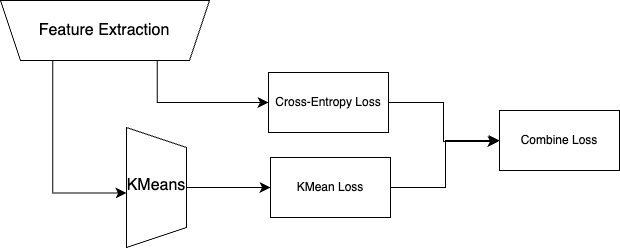

#### Team Member and Contribution

#### Code Libraries


| **Libraries**      | **Explanation**                                                                                  |
|---------------------|--------------------------------------------------------------------------------------------------|
| **NumPy**           |  Library for numerical computing in Python, providing support for arrays, matrices, and mathematical functions. |
| **Matplotlib**      | 2D plotting library for creating static, interactive, and animated visualizations in Python.  |
| **Scikit-learn**    | Used for implementation of KMeans algorithm |
| **PyTorch**         | Another deep learning framework, known for its flexibility and dynamic computation graph.         |

In [1]:


# importing essential libraries for basic image manipulations.
import numpy as np
import matplotlib.pyplot as plt



import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
import torchvision
import torchvision.transforms as transforms

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split, DataLoader, Subset
import torch.optim as optim

from sklearn.cluster import KMeans

### PART 1: 

In [2]:
# define device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      ("cuda" if torch.cuda.is_available() else "cpu"))

In [3]:
RANDOM_STATE = 50

Step 1: Data Preparation
  - Load CIFAR-10 dataset with transformations.
  - Split training data into labeled and unlabeled subsets.
  - Create dataloaders for labeled, unlabeled, and test data.

Step 2: labeled_labeled_model Definition
  - Define a CNN with:
    - Feature extraction layers.
    - Fully connected classification head.
  - Ensure labeled_labeled_model outputs:
    - Features for clustering.
    - Logits for classification.

Step 3: Loss Functions
  - Supervised Loss: Cross-entropy on labeled data.
  - Unsupervised Loss:
    - Perform K-Means on features of unlabeled data.
    - Compute clustering loss (e.g., mean distance to cluster centers).

Step 4: Training Loop
  For each epoch:
    - Train on Labeled Data (Supervised Step):
      - Load labeled batch.
      - Pass batch through the labeled_labeled_model.
      - Compute cross-entropy loss.
      - Backpropagate and update labeled_labeled_model.

    - Train on Unlabeled Data (Unsupervised Step):
      - Extract features for all unlabeled data.
      - Perform K-Means on features.
      - For each batch of unlabeled data:
        - Compute clustering loss.
        - Backpropagate and update labeled_labeled_model.

    - Log losses and progress.

Step 5: Testing and Evaluation
  - Evaluate on test set:
    - Compute accuracy using predicted labels.
  - Analyze performance at different labeled/unlabeled splits.

Step 6: Results Analysis
  - Plot training losses.
  - Visualize feature clustering with t-SNE.
  - Discuss how unlabeled data improved the labeled_labeled_model's performance.


Step 1: Data Preparation
  - Load CIFAR-10 dataset with transformations. Use pre-defined transformations
  - Split training data into labeled and unlabeled subsets.
  - Create dataloaders for labeled, unlabeled, and test data.

In [4]:
# # Define transformations
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
# ])

# # Load CIFAR-10 dataset (original training set only)
# full_trainset = torchvision.datasets.CIFAR10(
#     root='./data', train=True, download=True, transform=transform
# )

# # Split into 80% train and 20% validation
# train_size = int(0.8 * len(full_trainset))
# val_size = len(full_trainset) - train_size
# trainset, valset = random_split(full_trainset, [train_size, val_size])

# # Create DataLoaders for training and validation
# trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
# valloader = DataLoader(valset, batch_size=32, shuffle=False)

# # Load CIFAR-10 test set (unchanged)
# testset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform
# )
# testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [5]:
def get_cifar10_transforms():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

def load_cifar10_datasets(root='./data'):
    transform = get_cifar10_transforms()
    trainset = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    return trainset, testset


In [6]:
def create_labeled_unlabeled_subsets(trainset, labeled_ratio=0.2, unlabeled_ratio=1.0):

    # fix labeled portion at 20% of the training data (or possible to give another labeled_ratio)
    total_size = len(trainset)
    labeled_size = int(labeled_ratio * total_size)

    indices = torch.randperm(total_size).tolist()

    # labeled indices
    labeled_indices = indices[:labeled_size]

    # unlabeled indices
    unlabeled_indices = indices[labeled_size:]

    # from unlabeled pool choose fraction given by unlabeled_ratio
    chosen_unlabeled_size = int(len(unlabeled_indices) * unlabeled_ratio)
    chosen_unlabeled_indices = unlabeled_indices[:chosen_unlabeled_size]

    labeled_set = Subset(trainset, labeled_indices)
    unlabeled_set = Subset(trainset, chosen_unlabeled_indices) if chosen_unlabeled_size > 0 else None

    return labeled_set, unlabeled_set

# create dataloaders
def create_dataloaders(labeled_set, unlabeled_set, testset, batch_size=32):
    
    labeled_loader = DataLoader(labeled_set, batch_size=batch_size, shuffle=True)

    unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=True) if unlabeled_set is not None else None

    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return labeled_loader, unlabeled_loader, test_loader


   

In [7]:

trainset, testset = load_cifar10_datasets()

# Always 20% labeled
# For the benchmark scenario: unlabeled_ratio=0.0 means no unlabeled data used
labeled_set, unlabeled_set = create_labeled_unlabeled_subsets(trainset, labeled_ratio=0.2, unlabeled_ratio=0.0)
labeled_loader, unlabeled_loader, test_loader = create_dataloaders(labeled_set, unlabeled_set, testset, batch_size=32)


In [9]:
# function to
def get_device():
    return torch.device("mps" if torch.backends.mps.is_available() else 
                        ("cuda" if torch.cuda.is_available() else "cpu"))

In [10]:
# defined Convolutional Neural Network
# uses: 
class CNN(nn.Module):
    
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))  # [N,128,1,1]
        )

        self.classifier_head = nn.Linear(128, num_classes)
        
    def feature_extractor(self, x):
        x = self.conv(x)           # shape: [N, 128, 1, 1]
        x = x.view(x.size(0), -1)  # Flatten to [N, 128]
        return x
    
    def classifier(self, features):
        return self.classifier_head(features)
    
    def forward(self, x):
        f = self.feature_extractor(x)
        logits = self.classifier(f)
        return f, logits

In [11]:
# function to compute K clustroids
def compute_kmeans_centers(model, unlabeled_loader, device, K):
    model.eval()
    all_features = []
    with torch.no_grad():
        for u_inputs, _ in unlabeled_loader:
            u_inputs = u_inputs.to(device)
            u_features, _ = model(u_inputs)
            all_features.append(u_features.cpu().numpy())
    all_features = np.concatenate(all_features, axis=0)
    kmeans = KMeans(n_clusters=K, random_state=RANDOM_STATE)
    kmeans.fit(all_features)
    cluster_centers = kmeans.cluster_centers_
    return torch.tensor(cluster_centers, dtype=torch.float32, device=device)

Step 2: labeled_labeled_model Definition
  - Define a CNN with:
    - Feature extraction layers.
    - Fully connected classification head.
  - Ensure labeled_labeled_model outputs:
    - Features for clustering.
    - Logits for classification.

Use t-SNE or PCA to show clusters in the feature space ?

In [14]:
# # take in argument based on which we want to use, lets use c_e for now
# def supervised_loss(logits, labels):
#     return F.cross_entropy(logits, labels)


In [15]:
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, random_split
# from sklearn.cluster import KMeans
# import numpy as np

# # Define transformations
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # Load CIFAR-10 dataset
# full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# LABEL_SIZE = 0.2

# # Split into labeled and unlabeled datasets (20% labeled)
# labeled_size = int(LABEL_SIZE * len(full_trainset))
# unlabeled_size = len(full_trainset) - labeled_size
# labeled_set, unlabeled_set = random_split(full_trainset, [labeled_size, unlabeled_size])

# print(f"Labeled size: {labeled_size}, Unlabeled size: {unlabeled_size}")


# # Compute ratio
# ratio = unlabeled_size / labeled_size

# # A simple heuristic: if ratio is large, update K-Means less often
# # For instance, if ratio = 1 means run every epoch, if ratio=5 means run every 5 epochs
# kmeans_update_frequency = max(1, int(ratio))

# print(f"K-Means will be updated every {kmeans_update_frequency} epochs based on ratio={ratio:.2f}.")

# # Create DataLoaders for labeled and unlabeled datasets
# labeled_loader = DataLoader(labeled_set, batch_size=32, shuffle=True)
# unlabeled_loader = DataLoader(unlabeled_set, batch_size=32, shuffle=True)

# # Load CIFAR-10 test set
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# testloader = DataLoader(testset, batch_size=32, shuffle=False)

# # Define device
# device = torch.device("mps" if torch.backends.mps.is_available() else 
#                       ("cuda" if torch.cuda.is_available() else "cpu"))
# print(f"Using device: {device}")


# model = CNN().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 10
# K = 10  # number of clusters
# lambda_cluster = 0.5

# cluster_centers_torch = None  # will store cluster centers

# for epoch in range(num_epochs):
#     model.eval()
    
#     # Update K-Means only every kmeans_update_frequency epochs or if we have no cluster centers yet
#     if epoch % kmeans_update_frequency == 0 or cluster_centers_torch is None:
#         # ----- Run K-Means Clustering on Unlabeled Data -----
#         all_features = []
#         with torch.no_grad():
#             for unlabeled_batch in unlabeled_loader:
#                 u_inputs = unlabeled_batch[0].to(device)
#                 u_features, _ = model(u_inputs)
#                 all_features.append(u_features.cpu().numpy())
        
#         all_features = np.concatenate(all_features, axis=0)  # shape: [num_unlabeled_samples, feature_dim]

#         # Fit KMeans
#         kmeans = KMeans(n_clusters=K, random_state=42)
#         kmeans.fit(all_features)
#         cluster_centers = kmeans.cluster_centers_
#         cluster_centers_torch = torch.tensor(cluster_centers, dtype=torch.float32, device=device)
#         print(f"Updated K-Means at epoch {epoch+1}")

#     # Reset unlabeled loader iterator for this epoch
#     unlabeled_iter = iter(unlabeled_loader)

#     model.train()
#     running_supervised_loss = 0.0
#     running_cluster_loss = 0.0
    
#     for x_l, y_l in labeled_loader:
#         x_l, y_l = x_l.to(device), y_l.to(device)
        
#         # Get an unlabeled batch
#         try:
#             x_u, _ = next(unlabeled_iter)
#         except StopIteration:
#             unlabeled_iter = iter(unlabeled_loader)
#             x_u, _ = next(unlabeled_iter)
        
#         x_u = x_u.to(device)
        
#         # Compute supervised loss
#         f_l, logits_l = model(x_l)
#         supervised_loss = criterion(logits_l, y_l)
        
#         # Compute cluster loss for the unlabeled batch:
#         f_u, _ = model(x_u)
        
#         # Assign clusters by finding nearest center
#         with torch.no_grad():
#             dists = torch.cdist(f_u, cluster_centers_torch)
#             assignments = dists.argmin(dim=1)
        
#         assigned_centers = cluster_centers_torch[assignments]
#         cluster_loss = ((f_u - assigned_centers)**2).mean()
        
#         # Combine losses and backprop
#         total_loss = supervised_loss + lambda_cluster * cluster_loss
#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()
        
#         running_supervised_loss += supervised_loss.item()
#         running_cluster_loss += cluster_loss.item()
    
#     avg_supervised_loss = running_supervised_loss / len(labeled_loader)
#     avg_cluster_loss = running_cluster_loss / len(labeled_loader)
    
#     print(f"Epoch {epoch+1}/{num_epochs}: "
#           f"Supervised Loss = {avg_supervised_loss:.4f}, "
#           f"Cluster Loss = {avg_cluster_loss:.4f}")

# # ----- Evaluation -----
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for inputs, labels in testloader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         _, logits = model(inputs)
#         _, predicted = torch.max(logits, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [16]:
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, Subset
# from sklearn.cluster import KMeans
# import numpy as np

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            _, logits = model(inputs)
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# ---------------------
# Training Function
# ---------------------
def train_model(model, labeled_loader, unlabeled_loader, test_loader, device,
                num_epochs=10, lr=0.001, K=10, lambda_cluster=0.5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    # Determine how often to update K-Means
    # If no unlabeled data, ratio=1 (just default) and we won't actually run K-means
    if unlabeled_loader is not None and len(unlabeled_loader.dataset) > 0:
        unlabeled_size = len(unlabeled_loader.dataset)
        labeled_size = len(labeled_loader.dataset)
        ratio = unlabeled_size / labeled_size
    else:
        # No unlabeled data scenario: set ratio=1 for a default frequency
        ratio = 1.0
    
    kmeans_update_frequency = max(1, int(ratio))
    cluster_centers_torch = None

    # To record accuracy and losses per epoch
    epoch_stats = {
        "supervised_loss": [],
        "unsupervised_loss": [],
        "test_accuracy": []
    }


    for epoch in range(num_epochs):
        model.eval()

        # Update K-means if unlabeled data is present
        if unlabeled_loader is not None and len(unlabeled_loader.dataset) > 0:
            if epoch % kmeans_update_frequency == 0 or cluster_centers_torch is None:
                cluster_centers_torch = compute_kmeans_centers(model, unlabeled_loader, device, K)
                print(f"Updated K-Means at epoch {epoch+1}")
        else:
            # If no unlabeled data, no cluster centers
            cluster_centers_torch = None

        model.train()
        running_supervised_loss = 0.0
        running_cluster_loss = 0.0
        
        if unlabeled_loader is not None:
            unlabeled_iter = iter(unlabeled_loader)
        else:
            unlabeled_iter = None

        for x_l, y_l in labeled_loader:
            x_l, y_l = x_l.to(device), y_l.to(device)

            # Get an unlabeled batch if available
            if unlabeled_iter is not None:
                try:
                    x_u, _ = next(unlabeled_iter)
                except StopIteration:
                    unlabeled_iter = iter(unlabeled_loader)
                    x_u, _ = next(unlabeled_iter)
                x_u = x_u.to(device)
            else:
                x_u = None

            # Supervised loss
            f_l, logits_l = model(x_l)
            supervised_loss = criterion(logits_l, y_l)

            # Cluster loss only if we have unlabeled data and cluster centers
            if x_u is not None and cluster_centers_torch is not None:
                f_u, _ = model(x_u)
                with torch.no_grad():
                    dists = torch.cdist(f_u, cluster_centers_torch)
                    assignments = dists.argmin(dim=1)
                assigned_centers = cluster_centers_torch[assignments]
                cluster_loss = ((f_u - assigned_centers)**2).mean()
            else:
                cluster_loss = 0.0

            total_loss = supervised_loss + lambda_cluster * cluster_loss
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            running_supervised_loss += supervised_loss.item()
            if x_u is not None:
                running_cluster_loss += cluster_loss.item()

        avg_supervised_loss = running_supervised_loss / len(labeled_loader)
        if unlabeled_loader is not None:
            avg_cluster_loss = running_cluster_loss / len(labeled_loader)
        else:
            avg_cluster_loss = 0.0

        # Record losses
        epoch_stats["supervised_loss"].append(avg_supervised_loss)
        epoch_stats["unsupervised_loss"].append(avg_cluster_loss)

        # Evaluate model
        test_accuracy = evaluate(model, test_loader, device)
        epoch_stats["test_accuracy"].append(test_accuracy)
    
    # Evaluate at the end
    accuracy = evaluate(model, test_loader, device)

    # replace prints with TQDM if time
    print(f"Test Accuracy: {accuracy:.2f}%")
    return model, epoch_stats




In [17]:
import matplotlib.pyplot as plt

# probably dont need model labels
def plot_model_losses(epoch_stats_list, model_labels):
    """
    Plots supervised loss and cluster (unsupervised) loss for multiple models.
    
    Args:
        epoch_stats_list (list): List of `epoch_stats` dictionaries from different models.
        model_labels (list): List of labels for the corresponding models.
    """
    plt.figure(figsize=(12, 6))
    
    for epoch_stats, label in zip(epoch_stats_list, model_labels):
        epochs = range(1, len(epoch_stats["supervised_loss"]) + 1)
        # Plot supervised loss
        plt.plot(epochs, epoch_stats["supervised_loss"], label=f"{label} - Supervised Loss", linestyle='-', marker='o')
        # Plot cluster loss
        plt.plot(epochs, epoch_stats["cluster_loss"], label=f"{label} - Cluster Loss", linestyle='--', marker='x')
    
    plt.title("Supervised and Cluster Losses for Each Model")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:

# Always 20% labeled
# For the benchmark scenario: unlabeled_ratio=0.0 means no unlabeled data used
labeled_set, unlabeled_set = create_labeled_unlabeled_subsets(trainset, labeled_ratio=0.2, unlabeled_ratio=0)
labeled_loader, unlabeled_loader, test_loader = create_dataloaders(labeled_set, unlabeled_set, testset, batch_size=32)

# Train model
base_model = CNN()
base_model, base_stats = train_model(base_model, labeled_loader, unlabeled_loader, test_loader, device,
            num_epochs=10, lr=0.001, K=10, lambda_cluster=0.5)


Updated K-Means at epoch 1
Updated K-Means at epoch 5
Updated K-Means at epoch 9


In [1]:

# models = []
# epoch_stats = []

# unlabeled_ratios = values = [round(x * 0.2, 1) for x in range(1, 6)]  # Multiples of 0.2 from 0.2 to 1.0

# for unlabeled_ratio in unlabeled_ratios:
#     labeled_set, unlabeled_set = create_labeled_unlabeled_subsets(trainset, labeled_ratio=0.2, unlabeled_ratio=1)
#     labeled_loader, unlabeled_loader, test_loader = create_dataloaders(labeled_set, unlabeled_set, testset, batch_size=32)

#     # train models with the ratios
#     model = CNN()

#     tmodel, epoch_stats = train_model(model, labeled_loader, unlabeled_loader, test_loader, device,
#                 num_epochs=10, lr=0.001, K=10, lambda_cluster=0.5)

#     # save model     
#     models.append(model)

#     epoch_stats.append(epoch_stats)
   
# Generate unlabeled ratios
unlabeled_ratios = [round(x * 0.2, 1) for x in range(1, 6)]  # Multiples of 0.2 from 0.2 to 1.0

models = []
all_epoch_stats = []  # To store epoch_stats for all models
model_labels = []  # To store model labels for plotting

for unlabeled_ratio in unlabeled_ratios:
    # Create labeled and unlabeled subsets
    labeled_set, unlabeled_set = create_labeled_unlabeled_subsets(trainset, labeled_ratio=0.2, unlabeled_ratio=unlabeled_ratio)
    labeled_loader, unlabeled_loader, test_loader = create_dataloaders(labeled_set, unlabeled_set, testset, batch_size=32)

    # Train the model with the current ratio
    model = CNN()
    trained_model, epoch_stats = train_model(model, labeled_loader, unlabeled_loader, test_loader, device,
                                             num_epochs=10, lr=0.001, K=10, lambda_cluster=0.5)

    # Save model and stats
    models.append(trained_model)
    all_epoch_stats.append(epoch_stats)
    model_labels.append(f"Unlabeled Ratio {unlabeled_ratio:.1f}")


NameError: name 'create_labeled_unlabeled_subsets' is not defined

In [ ]:
# Plot supervised and cluster losses for all models
plot_model_losses(all_epoch_stats, model_labels)

In [114]:
# # from sklearn.manifold import TSNE
# # import matplotlib.pyplot as plt

# # # extracting the features from last layer
# # def extract_features(model, dataloader, device):
# #     model.eval()
# #     all_features = []
# #     all_labels = []

# #     with torch.no_grad():
# #         for inputs, labels in dataloader:
# #             inputs, labels = inputs.to(device), labels.to(device)
# #             features = model.feature_extractor(inputs)  # shape: [batch_size, feature_dim]
# #             all_features.append(features.cpu().numpy())
# #             all_labels.append(labels.cpu().numpy())

# #     all_features = np.concatenate(all_features, axis=0)
# #     all_labels = np.concatenate(all_labels, axis=0)
# #     return all_features, all_labels

# # def visualize_tsne(features, labels, title="t-SNE Visualization"):

#  #    # apply tSNE
# #     tsne = TSNE(n_components=2, random_state=RANDOM_STATE)

#     feature# s_2d = tsne.fit_transform(features)

#     # Plot # results
#     plt.fig# ure(figsize=(10, 8))
#     scatter#  = plt.scatter(features_2d[:,0], features_2d[:,1], c=labels, cmap='tab10', alpha=0.7)
#     plt.col# orbar(scatter, ticks=range(10))
#     plt.tit# le(title)
#     plt.sho# w()

# # Example u# sage after training:
# # Assume `m# odel` is trained, `testloader` is ready, and `device` is defined

# # have 'models' right now. 
# # probably want to run tSNE for the benchmark model (trained with only labeled data), and the last trained model (using all unlabeled data)
# features, la# bels = extract_features(mode# l, testloader, device)
# visualize_tsne(features, labels, title="t-SNE of Test Set Features")
# # # 

NameError: name 'RANDOM_STATE' is not defined

For each epoch:
    1. Supervised Phase:
        - For each batch in labeled_loader:
            a. Pass images through the labeled_labeled_model to get predictions (logits).
            b. Compute supervised loss (cross-entropy).
            c. Backpropagate and update labeled_labeled_model weights.

    2. Unsupervised Phase:
        a. Extract features for all images in unlabeled_loader.
        b. Perform clustering (e.g., K-Means) on the features.
        c. For each batch in unlabeled_loader:
            - Compute clustering loss (distance to cluster centers).
            - Backpropagate and update the feature extractor.

    Log both supervised and unsupervised losses.
    Evaluate on the test set to track performance.


#### Conclusions